In [1]:
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split

In [2]:

df = pd.read_csv("../data/case_item_1023(in).csv")

<Axes: title={'center': 'Monthly Case Submitted Distribution'}, xlabel='month'>

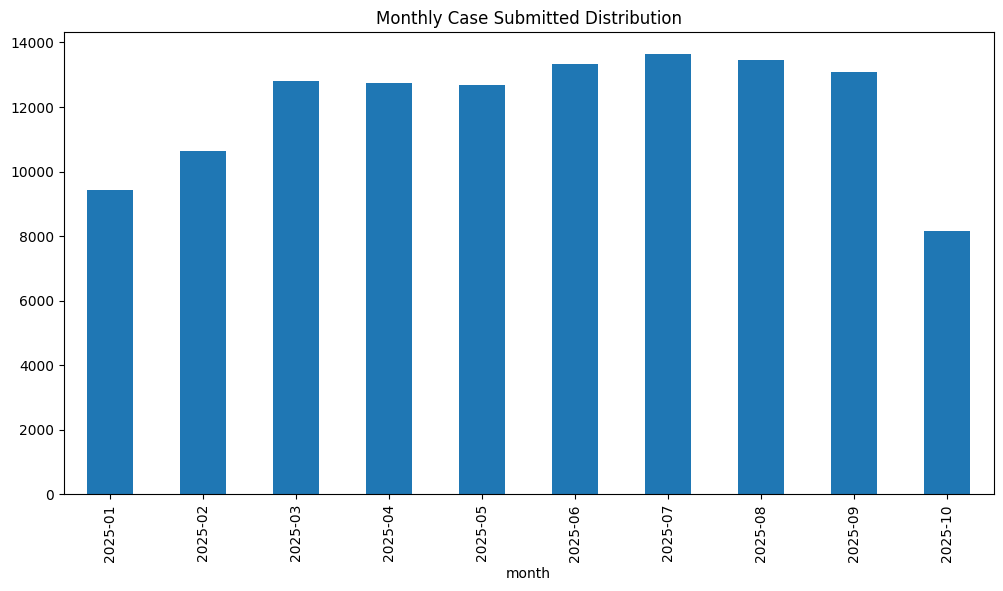

In [5]:
df["case_submitted_date"].value_counts()
# 按照月份绘制柱状图
df['month'] = pd.to_datetime(df['case_submitted_date']).dt.to_period('M')
monthly_counts = df['month'].value_counts().sort_index()
monthly_counts.plot(kind='bar', figsize=(12, 6), title='Monthly Case Submitted Distribution')

In [6]:
df.shape

(119989, 10)

In [7]:
df = df.drop(columns=['Unnamed: 0'])
duplicate_rows = df[df.duplicated()]
df.shape

(119989, 9)

In [8]:
df['case_submitted_date'] = pd.to_datetime(df['case_submitted_date'])
unknown_item_df = df[df['linked_items'].isnull()]
unknown_item_df.to_csv("../output/2025_unknown.csv", index=False)
df = df.drop(unknown_item_df.index)
# df

In [9]:
unknown_item_df.shape , df.shape

((22784, 9), (97205, 9))

<Axes: title={'center': 'Monthly Case Submitted Distribution'}, xlabel='month'>

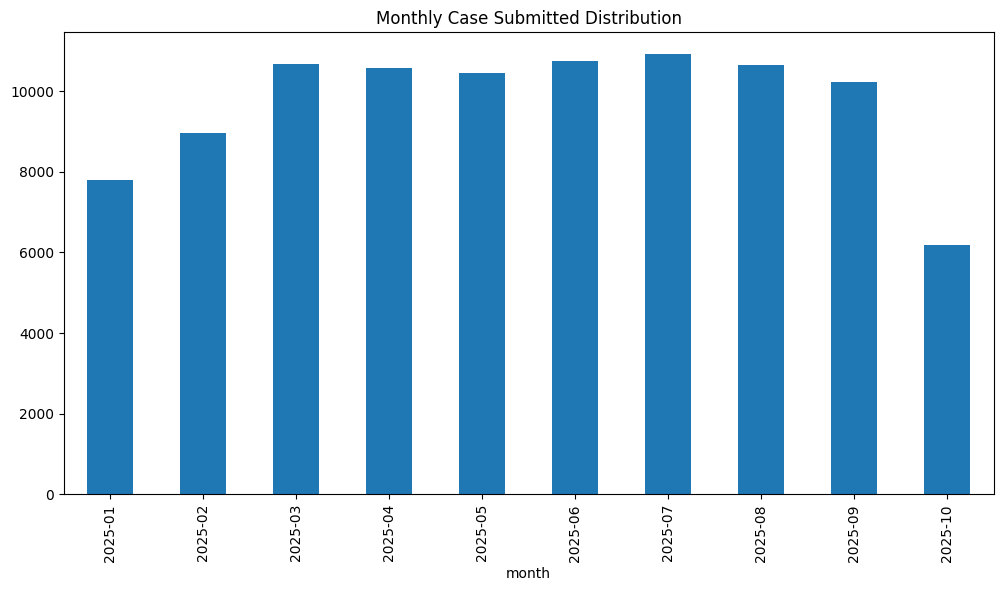

In [10]:
monthly_counts = df['month'].value_counts().sort_index()
monthly_counts.plot(kind='bar', figsize=(12, 6), title='Monthly Case Submitted Distribution')

In [11]:
monthly_counts

month
2025-01     7805
2025-02     8973
2025-03    10680
2025-04    10580
2025-05    10437
2025-06    10746
2025-07    10915
2025-08    10654
2025-09    10237
2025-10     6178
Freq: M, Name: count, dtype: int64

month
2025-01     7805
2025-02     8973
2025-03    10680
2025-04    10580
2025-05    10437
2025-06    10746
2025-07    10915
2025-08    10654
2025-09    10237
2025-10     6178
Freq: M, Name: count, dtype: int64

In [7]:



# 构造一批train,eval,test
# 拿123456训练，预测7
# 拿1234567训练，预测8
# 拿12345678训练，预测9
# 拿123456789训练，预测10

test_points = [
    {"train": [1, 2, 3, 4, 5, 6], "test": 7},
    {"train": [1, 2, 3, 4, 5, 6, 7], "test": 8},
    {"train": [1, 2, 3, 4, 5, 6, 7, 8], "test": 9},
    {"train": [1, 2, 3, 4, 5, 6, 7, 8, 9], "test": 10},
]

# 按照月份对df进行划分
df['month'] = pd.to_datetime(df['case_submitted_date']).dt.to_period('M')
month_groups = df.groupby('month')


for point in test_points:
    train_months = point['train']
    test_month = point['test']
    
    train_df = pd.concat([month_groups.get_group(month) for month in month_groups.groups if month.month in train_months])
    test_df = month_groups.get_group(next(month for month in month_groups.groups if month.month == test_month))
    
    # 确保输出目录存在
    out_dir = Path(f"../output/2025_up_to_month_{test_month}")
    out_dir.mkdir(parents=True, exist_ok=True)

    # 按标签分层切分 train -> train/eval
    eval_size = 0.2
    try:
        tr_df, ev_df = train_test_split(
            train_df,
            test_size=eval_size,
            random_state=42,
            stratify=train_df['linked_items'].astype(str)
        )
    except ValueError:
        # 某些类别样本过少导致分层失败，退化为非分层
        tr_df, ev_df = train_test_split(
            train_df,
            test_size=eval_size,
            random_state=42,
            shuffle=True
        )

    # 保存文件
    tr_df.to_csv(out_dir / "train.csv", index=False)
    ev_df.to_csv(out_dir / "eval.csv", index=False)
    test_df.to_csv(out_dir / "test.csv", index=False)
